## Проект "Определение перспективного тарифа для телеком-компании"

### Описание проекта
##### Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
##### Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#####  Тариф «Смарт»

**Ежемесячная плата:** 550 рублей  

##### Включено в тариф:
- 500 минут разговора  
- 50 сообщений  
- 15 ГБ интернет-трафика  

##### Стоимость услуг сверх тарифного пакета:
- Минута разговора — **3 рубля**  
- Сообщение — **3 рубля**  
- 1 ГБ интернет-трафика — **200 рублей**  



##### Тариф «Ультра»

**Ежемесячная плата:** 1950 рублей  

##### Включено в тариф:
- 3000 минут разговора  
- 1000 сообщений  
- 30 ГБ интернет-трафика  

##### Стоимость услуг сверх тарифного пакета:
- Минута разговора — **1 рубль**  
- Сообщение — **1 рубль**  
- 1 ГБ интернет-трафика — **150 рублей**  




##### Примечание

- Компания «Мегалайн» округляет **секунды до минут**, а **мегабайты — до гигабайт**.  
- Каждый звонок округляется отдельно: даже если он длился 1 секунду, будет засчитан как 1 минута.  
- Для интернет-трафика отдельные сессии не учитываются. Считается общая сумма за месяц, которая округляется **в большую сторону**.  
  - Например, если абонент использовал 1025 МБ за месяц, будет начислена плата за 2 ГБ.  
- Неиспользованные минуты, сообщения и интернет-трафик на следующий месяц **не переносятся**.

### Шаг 1. Откроем файлы с данными и изучим общую информацию

##### Подключим необходимые библиотеки и настроим формат вывода 

In [62]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.2f}'.format)

##### Изучим общую информацию о каждом датасете (структура, типы данных и т.д.)

In [63]:
df_calls=pd.read_csv('calls.csv')

display(df_calls.head(),df_calls.info())

df_internet=pd.read_csv('internet.csv')

display(df_internet.head(),df_internet.info())

df_messages=pd.read_csv('messages.csv')

display(df_messages.head(),df_messages.info())

df_tariffs=pd.read_csv('tariffs.csv')

display(df_tariffs.head(),df_tariffs.info())

df_users=pd.read_csv('users.csv')

display(df_users.head(),df_users.info(),df_users[df_users['churn_date'].isna()==False].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


##### Почти во всех датасетах проблемы с типом данных дата:
* В users исправим reg_date и churn_date
* В messages исправим message_date
* В internet уберем столбец unnamed - лишний столбец попал видимо по ошибке (он просто дублирует индексы), а также исправим session_date
* В calls исправим call_date

##### Шаг 2. Подготовим данные

##### Приведём данные к нужным типам. Найдём и исправим ошибки в данных, если они есть.


In [64]:
df_users['churn_date']=pd.to_datetime(df_users['churn_date'])

df_users['reg_date']=pd.to_datetime(df_users['reg_date'])

df_messages['message_date']=pd.to_datetime(df_messages['message_date'])

df_internet=df_internet.loc[:,'id':'user_id']

df_internet['session_date']=pd.to_datetime(df_internet['session_date'])

df_calls['call_date']=pd.to_datetime(df_calls['call_date'])

##### Просмотрим аномальные значения

In [65]:
display(df_calls.describe())

display(df_internet.describe())

display(df_messages.describe())

display(df_users.describe())

,call_date,duration,user_id
count,202607,202607.00,202607.00
mean,2018-09-02 20:01:37.583992832,6.76,1253.94
min,2018-01-01 00:00:00,0.00,1000.00
25%,2018-07-05 00:00:00,1.30,1126.00
50%,2018-09-17 00:00:00,6.00,1260.00
75%,2018-11-14 00:00:00,10.70,1379.00
max,2018-12-31 00:00:00,38.00,1499.00
std,NaN,5.84,144.72


,mb_used,session_date,user_id
count,149396.00,149396,149396.00
mean,370.19,2018-09-02 12:55:35.221826560,1252.10
min,0.00,2018-01-01 00:00:00,1000.00
25%,138.19,2018-07-05 00:00:00,1130.00
50%,348.01,2018-09-17 00:00:00,1251.00
75%,559.55,2018-11-14 00:00:00,1380.00
max,1724.83,2018-12-31 00:00:00,1499.00
std,278.30,NaN,144.05


,message_date,user_id
count,123036,123036.00
mean,2018-09-04 15:28:42.227640576,1256.99
min,2018-01-02 00:00:00,1000.00
25%,2018-07-09 00:00:00,1134.00
50%,2018-09-20 00:00:00,1271.00
75%,2018-11-14 00:00:00,1381.00
max,2018-12-31 00:00:00,1499.00
std,NaN,143.52


,user_id,age,churn_date,reg_date
count,500.00,500.00,38,500
mean,1249.50,46.59,2018-11-13 00:37:53.684210432,2018-06-30 18:57:35.999999744
min,1000.00,18.00,2018-08-17 00:00:00,2018-01-01 00:00:00
25%,1124.75,32.00,2018-10-14 00:00:00,2018-04-07 12:00:00
50%,1249.50,46.00,2018-11-24 00:00:00,2018-07-02 12:00:00
75%,1374.25,62.00,2018-12-15 12:00:00,2018-09-29 00:00:00
max,1499.00,75.00,2018-12-30 00:00:00,2018-12-31 00:00:00
std,144.48,16.67,NaN,NaN


##### Заполнение пропусков. В предыдущих вычислениях заметили что в churn_date всего 38 заполненых значений (из 500). Нули означают, что человек продолжает пользоваться тарифом. Не будем заполнять эти пропуски, т.к. в дальнейшей работе churn не понадобиться.

##### Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества
* звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте 
* абонентскую плату, соответствующую тарифному плану).

Количество сделанных звонков и израсходованных минут разговора по месяцам:

In [66]:
df_calls['month']=df_calls['call_date'].dt.month

df_calls['real_duration']=df_calls['duration']

df_calls['duration']=np.ceil(df_calls['duration'])

display(df_calls)

pivot_calls=(df_calls.pivot_table(values='duration',index=['user_id','month'],aggfunc={'sum','count'}))

display(pivot_calls)

,id,call_date,duration,user_id,month,real_duration
0,1000_0,2018-07-25,0.00,1000,7,0.00
1,1000_1,2018-08-17,0.00,1000,8,0.00
2,1000_2,2018-06-11,3.00,1000,6,2.85
3,1000_3,2018-09-21,14.00,1000,9,13.80
4,1000_4,2018-12-15,6.00,1000,12,5.18
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1.00,1499,12,0.76
202603,1499_216,2018-10-18,19.00,1499,10,18.83
202604,1499_217,2018-11-10,11.00,1499,11,10.81
202605,1499_218,2018-10-06,5.00,1499,10,4.27


count    sum
user_id month              
1000    5         22 159.00
        6         43 172.00
        7         47 340.00
        8         52 408.00
        9         58 466.00
...              ...    ...
1498    10        41 247.00
1499    9          9  70.00
        10        68 449.00
        11        74 612.00
        12        69 492.00

[3174 rows x 2 columns]

Количество отправленных сообщений по месяцам:

In [67]:
df_messages['month']=df_messages['message_date'].dt.month

display(df_messages)

pivot_messages=(df_messages.pivot_table(values='id',index=['user_id','month'],aggfunc='count'))
pivot_messages.columns=['Кол-во сообщений']

display(pivot_messages)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


Кол-во сообщений
user_id month                  
1000    5                    22
        6                    60
        7                    75
        8                    81
        9                    57
...                         ...
1498    10                   42
1499    9                    11
        10                   48
        11                   59
        12                   66

[2717 rows x 1 columns]

Объем израсходованного интернет-трафика по месяцам:

In [68]:
df_internet['month']=df_internet['session_date'].dt.month

display(df_internet)

pivot_internet=(df_internet.pivot_table(values='mb_used',index=['user_id','month'],aggfunc='sum'))

pivot_internet.columns=['Трафик']

display(pivot_internet)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


Трафик
user_id month         
1000    5      2253.49
        6     23233.77
        7     14003.64
        8     14055.93
        9     14568.91
...                ...
1498    10    20579.36
1499    9      1845.75
        10    17788.51
        11    17963.31
        12    13055.58

[3203 rows x 1 columns]

Добавим в таблицу тип тарифа пользователя

In [69]:
res=pivot_internet.reset_index()

asd=(df_users.loc[:,['tariff','user_id']])

res=(res.merge(asd,on='user_id',how='left'))

res['Трафик']=np.ceil(res['Трафик']/1024)

def internet(x):
    if x['Трафик']>15 and x['tariff']=='smart':
        return (x['Трафик']-15)*200
    elif x['Трафик']>30 and x['tariff']=='ultra':
        return (x['Трафик']-30)*150
    else:
        return 0

res['asd']=(res.apply(lambda x: internet(x),axis=1))


res.columns=['user_id','month','интернет','tariff','перерасчет']

display(res[res['интернет']!=0])

display(res.loc[res['перерасчет']!=0,'tariff'].value_counts())

display(res['tariff'].value_counts())


,user_id,month,интернет,tariff,перерасчет
0,1000,5,3.00,ultra,0.00
1,1000,6,23.00,ultra,0.00
2,1000,7,14.00,ultra,0.00
3,1000,8,14.00,ultra,0.00
4,1000,9,15.00,ultra,0.00
...,...,...,...,...,...
3198,1498,10,21.00,smart,1200.00
3199,1499,9,2.00,smart,0.00
3200,1499,10,18.00,smart,600.00
3201,1499,11,18.00,smart,600.00


tariff
smart    1304
ultra     134
Name: count, dtype: int64

tariff
smart    2228
ultra     975
Name: count, dtype: int64

Добавим информацию о сообщениях

In [70]:
mes=pivot_messages.reset_index()

mes=mes.merge(asd,on='user_id',how='left')

def messages(x):
    if (x['Кол-во сообщений']>50)&(x['tariff']=='smart')==True:
        return (x['Кол-во сообщений']-50)*3
    elif (x['Кол-во сообщений']>1000)&(x['tariff']=='ultra')==True:
        return (x['Кол-во сообщений']-1000)
    else:
        return 0

mes['перерасход']=mes.apply(lambda x: messages(x),axis=1)

display(mes.loc[(mes['перерасход']!=0)])

display(mes.loc[(mes['перерасход']!=0),'tariff'].value_counts())

,user_id,month,Кол-во сообщений,tariff,перерасход
30,1005,3,56,smart,18
34,1005,7,56,smart,18
35,1005,8,64,smart,42
36,1005,9,52,smart,6
38,1005,11,51,smart,3
...,...,...,...,...,...
2665,1490,7,62,smart,36
2705,1496,12,51,smart,3
2710,1498,8,62,smart,36
2715,1499,11,59,smart,27


tariff
smart    564
Name: count, dtype: int64

Заметим что, нет пользователей тарифа ультра что зашли бы за лимит

Посчитаем перерасход минут 

In [71]:
ces=pivot_calls.reset_index()

ces=ces.merge(asd,on='user_id',how='left')

display(ces)

def calls(x):
    if x['sum']>500 and x['tariff']=='smart':
        return (x['sum']-500)*3
    elif x['sum']>3000 and x['tariff']=='ultra':
        return (x['sum']-3000)
    else:
        return 0

ces['перерасход минут']=ces.apply(lambda x : calls(x),axis=1)

print(ces[ces['перерасход минут']!=0])

,user_id,month,count,sum,tariff
0,1000,5,22,159.00,ultra
1,1000,6,43,172.00,ultra
2,1000,7,47,340.00,ultra
3,1000,8,52,408.00,ultra
4,1000,9,58,466.00,ultra
...,...,...,...,...,...
3169,1498,10,41,247.00,smart
3170,1499,9,9,70.00,smart
3171,1499,10,68,449.00,smart
3172,1499,11,74,612.00,smart


      user_id  month  count    sum tariff  перерасход минут
32       1005      3     77 606.00  smart            318.00
33       1005      4    101 712.00  smart            636.00
34       1005      5     73 595.00  smart            285.00
35       1005      6     80 612.00  smart            336.00
36       1005      7     77 569.00  smart            207.00
...       ...    ...    ...    ...    ...               ...
3158     1496      8     88 527.00  smart             81.00
3161     1496     11     80 662.00  smart            486.00
3162     1496     12     80 518.00  smart             54.00
3165     1497     12     71 545.00  smart            135.00
3172     1499     11     74 612.00  smart            336.00

[754 rows x 6 columns]


Посчитаем перерасход сообщений и трафика, а также сумму перерасчета

In [72]:
ces = ces.merge(
    res.loc[:, ['user_id', 'month', 'перерасчет', 'интернет']],
    on=['user_id', 'month'],
    how='outer'
)

ces = ces.merge(
    mes.loc[:, ['user_id', 'month', 'перерасход', 'Кол-во сообщений']],
    on=['user_id', 'month'],
    how='outer'
)

ces.columns=['user_id', 'month', 'кол-во звонков', 'минут', 'tariff', 'перерасход минут',
       'перерасход интернет', 'интернет', 'перерасход сообщения', 'кол-во сообщений']

def income(x):
    if x['tariff']=='smart':
       return x['перерасход минут'] + x['перерасход интернет'] + x['перерасход сообщения'] + 550
    if x['tariff']=='ultra':
        return x['перерасход минут'] + x['перерасход интернет'] + x['перерасход сообщения'] + 1950


ces=ces[['user_id', 'month', 'кол-во звонков', 'минут', 'интернет' ,'кол-во сообщений', 'tariff', 'перерасход минут',
       'перерасход интернет', 'перерасход сообщения']]

ces=ces.fillna(0)

ces['выручка']=ces.apply(lambda x: income(x), axis=1)

display(ces)



,user_id,month,кол-во звонков,минут,интернет,кол-во сообщений,tariff,перерасход минут,перерасход интернет,перерасход сообщения,выручка
0,1000,5,22.00,159.00,3.00,22.00,ultra,0.00,0.00,0.00,1950.00
1,1000,6,43.00,172.00,23.00,60.00,ultra,0.00,0.00,0.00,1950.00
2,1000,7,47.00,340.00,14.00,75.00,ultra,0.00,0.00,0.00,1950.00
3,1000,8,52.00,408.00,14.00,81.00,ultra,0.00,0.00,0.00,1950.00
4,1000,9,58.00,466.00,15.00,57.00,ultra,0.00,0.00,0.00,1950.00
...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.00,247.00,21.00,42.00,smart,0.00,1200.00,0.00,1750.00
3210,1499,9,9.00,70.00,2.00,11.00,smart,0.00,0.00,0.00,550.00
3211,1499,10,68.00,449.00,18.00,48.00,smart,0.00,600.00,0.00,1150.00
3212,1499,11,74.00,612.00,18.00,59.00,smart,336.00,600.00,27.00,1513.00


##### Проанализируем данные
* Опишем поведение клиентов оператора, исходя из выборки. 
* Определим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.
* Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы. Опишем распределения.

Пропуски, появившиеся в результате слияния таблиц (пользователь не отправил сообщение - nan), заполним нулями.

In [73]:
ces['минут']=ces['минут'].fillna(0)
ces['интернет']=ces['интернет'].fillna(0)
ces['кол-во сообщений']=ces['кол-во сообщений'].fillna(0)

display(ces.pivot_table(values='минут',index='tariff',aggfunc='mean'))

display(ces.pivot_table(values='интернет', index='tariff',aggfunc='mean'))

display(ces.pivot_table(values='кол-во сообщений', index='tariff',aggfunc='mean'))

,минут
tariff,
0,0.00
smart,419.06
ultra,545.45


,интернет
tariff,
0,19.12
smart,16.33
ultra,19.49


,кол-во сообщений
tariff,
0,54.12
smart,33.40
ultra,49.03


Рассмотрим статисктики звонков пользователей и графики распределений минут разговоров и количество сделаных звонков.

'Статистики smart:'

count   2223.00
mean     419.06
std      189.33
min        0.00
25%      285.00
50%      423.00
75%      545.50
max     1435.00
Name: минут, dtype: float64

np.float64(35844.1895513438)

'Статистики ultra:'

count    951.00
mean     545.45
std      306.93
min        0.00
25%      310.00
50%      528.00
75%      756.50
max     1673.00
Name: минут, dtype: float64

np.float64(94203.41839614812)

'Доля пользователей smart зашедших за лимит:'

np.float64(0.3391812865497076)

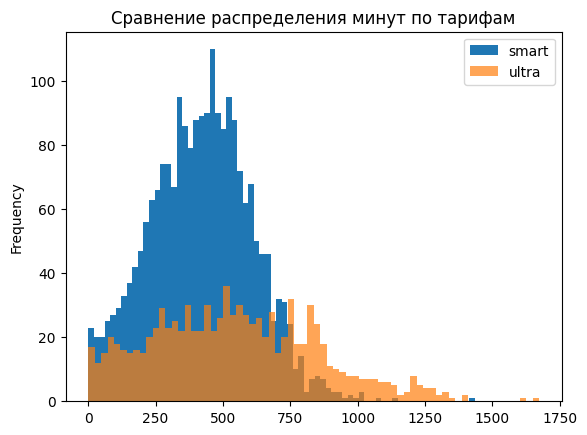

/var/folders/5h/4f18v2q96gv2lm0t_b6g7klc0000gn/T/ipykernel_53988/14895562.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


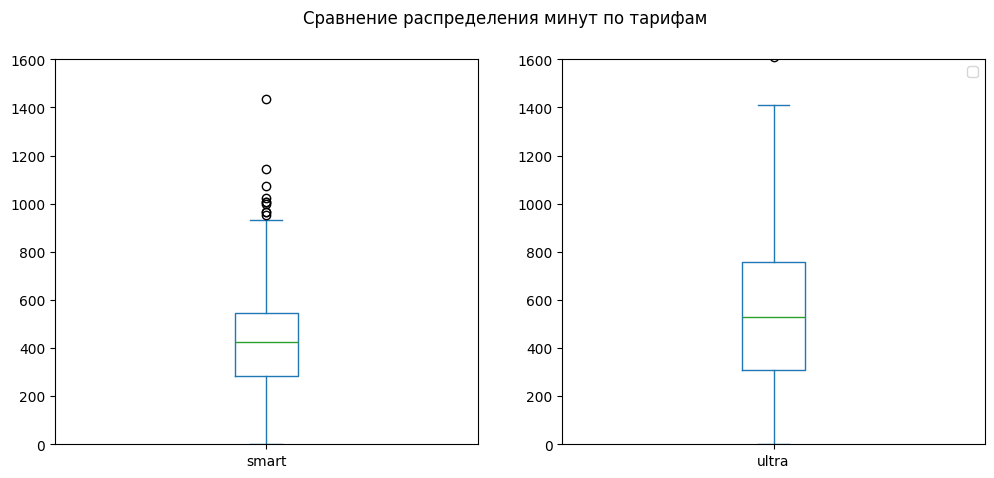

In [74]:
df_calls_smart=ces.loc[ces['tariff']=='smart','минут']

df_calls_ultra=ces.loc[ces['tariff']=='ultra','минут']

display('Статистики smart:',df_calls_smart.describe(),df_calls_smart.var())
display('Статистики ultra:',df_calls_ultra.describe(),df_calls_ultra.var())

display('Доля пользователей smart зашедших за лимит:',df_calls_smart[df_calls_smart>500].count()/len(df_calls_smart))

df_calls_smart.plot(kind='hist',bins=70,label='smart')
df_calls_ultra.plot(kind='hist',bins=70,label='ultra',alpha=0.7)
plt.title('Сравнение распределения минут по тарифам')
plt.legend()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

df_calls_smart.plot(ax=ax1,kind='box',label='smart')
df_calls_ultra.plot(ax=ax2,kind='box',label='ultra')
ax1.set_ylim(0,1600)
ax2.set_ylim(0,1600)
plt.legend()
plt.suptitle('Сравнение распределения минут по тарифам')
plt.show()



'Статистики smart:'

count   2223.00
mean      58.62
std       25.80
min        1.00
25%       40.00
50%       60.00
75%       76.00
max      198.00
Name: кол-во звонков, dtype: float64

np.float64(665.4388289031333)

'Статистики ultra:'

count   951.00
mean     76.02
std      42.40
min       1.00
25%      43.00
50%      75.00
75%     105.00
max     244.00
Name: кол-во звонков, dtype: float64

np.float64(1798.043927168078)

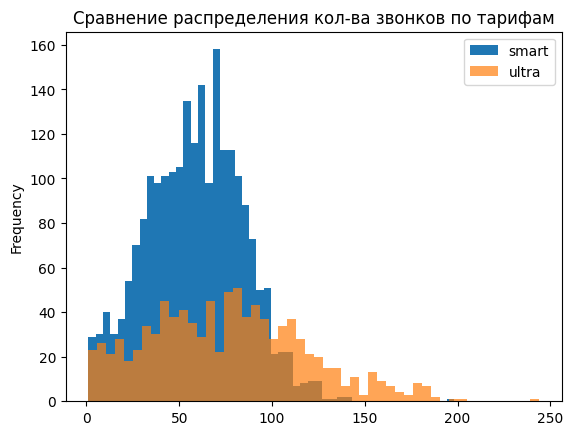

/var/folders/5h/4f18v2q96gv2lm0t_b6g7klc0000gn/T/ipykernel_53988/2222804074.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


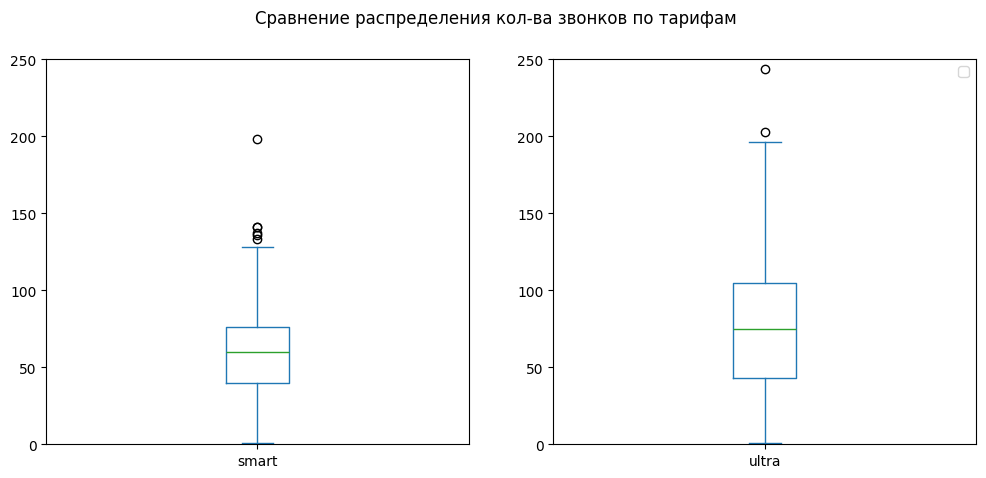

In [75]:
df_calls_smart_count=ces.loc[ces['tariff']=='smart','кол-во звонков']

df_calls_ultra_count=ces.loc[ces['tariff']=='ultra','кол-во звонков']

display('Статистики smart:',df_calls_smart_count.describe(),df_calls_smart_count.var())
display('Статистики ultra:',df_calls_ultra_count.describe(),df_calls_ultra_count.var())

df_calls_smart_count.plot(kind='hist',bins=50,label='smart')
df_calls_ultra_count.plot(kind='hist',bins=50,label='ultra',alpha=0.7)
plt.title('Сравнение распределения кол-ва звонков по тарифам')
plt.legend()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

df_calls_smart_count.plot(ax=ax1,kind='box',label='smart')
df_calls_ultra_count.plot(ax=ax2,kind='box',label='ultra')
ax1.set_ylim(0,250)
ax2.set_ylim(0,250)
plt.legend()
plt.suptitle('Сравнение распределения кол-ва звонков по тарифам')
plt.show()



Рассмотрим статисктики трафика пользователей и графики его распределения.

'Статистки трафика пользователей smart: '

count   2223.00
mean      16.33
std        5.75
min        0.00
25%       13.00
50%       17.00
75%       20.00
max       38.00
Name: интернет, dtype: float64

'Статистки трафика пользователей ultra: '

count   951.00
mean     19.49
std       9.89
min       0.00
25%      12.00
50%      19.00
75%      27.00
max      49.00
Name: интернет, dtype: float64

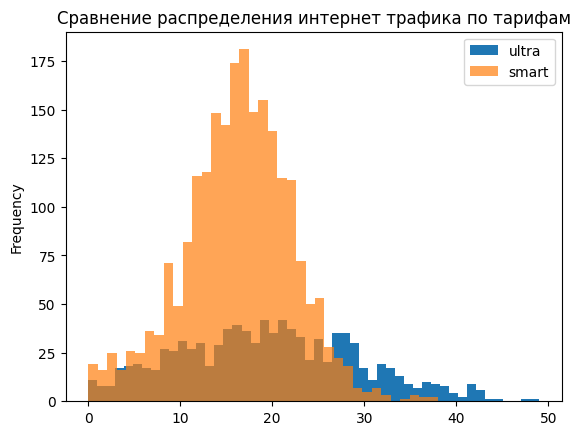

/var/folders/5h/4f18v2q96gv2lm0t_b6g7klc0000gn/T/ipykernel_53988/293403123.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


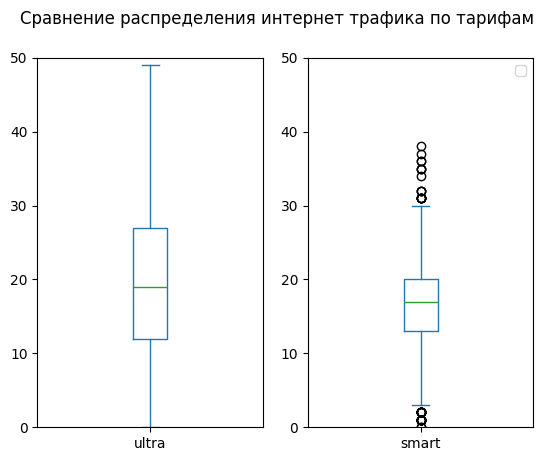

In [76]:
df_internet_smart=ces.loc[ces['tariff']=='smart','интернет']

df_internet_ultra=ces.loc[ces['tariff']=='ultra','интернет']

display('Статистки трафика пользователей smart: ',df_internet_smart.describe(),'Статистки трафика пользователей ultra: ',df_internet_ultra.describe())

df_internet_ultra.plot(bins=50,kind='hist',label='ultra')
df_internet_smart.plot(bins=37,kind='hist',alpha=0.7,label='smart')
plt.title('Сравнение распределения интернет трафика по тарифам')
plt.legend()
plt.show()

fig, (ax1, ax2) =plt.subplots(1,2)
df_internet_ultra.plot(ax=ax1,kind='box',label='ultra')
ax1.set_ylim(0,50)
df_internet_smart.plot(ax=ax2,kind='box',label='smart')
ax2.set_ylim(0,50)
plt.legend()
plt.suptitle('Сравнение распределения интернет трафика по тарифам')
plt.show()

Рассмотрим статисктики отправленых сообщений пользователей и графики их распределений.

'Статистика сообщений у smart:'

count   2223.00
mean      33.40
std       28.26
min        0.00
25%       10.00
50%       28.00
75%       51.00
max      143.00
Name: кол-во сообщений, dtype: float64

np.float64(33.396311291048136)

'Статистика сообщений у ultra:'

count   951.00
mean     49.03
std      46.89
min       0.00
25%       5.00
50%      39.00
75%      79.00
max     224.00
Name: кол-во сообщений, dtype: float64

np.float64(49.03364879074658)

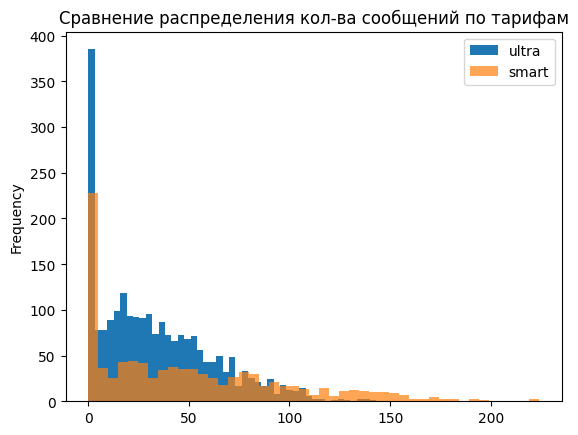

/var/folders/5h/4f18v2q96gv2lm0t_b6g7klc0000gn/T/ipykernel_53988/2866600714.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


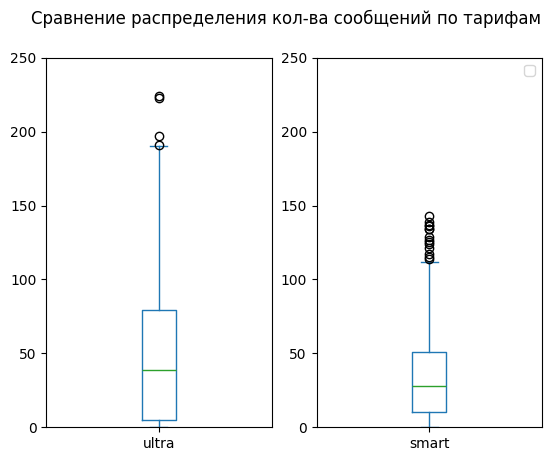

In [77]:
df_messages_smart=ces.loc[ces['tariff']=='smart','кол-во сообщений']

df_messages_ultra=ces.loc[ces['tariff']=='ultra','кол-во сообщений']

display('Статистика сообщений у smart:',df_messages_smart.describe(),df_messages_smart.mean())
display('Статистика сообщений у ultra:',df_messages_ultra.describe(),df_messages_ultra.mean())

df_messages_smart.plot(bins=45,kind='hist',label='ultra')
df_messages_ultra.plot(bins=45,kind='hist',alpha=0.7,label='smart')
plt.title('Сравнение распределения кол-ва сообщений по тарифам')
plt.legend()
plt.show()

fig, (ax1, ax2) =plt.subplots(1,2)
df_messages_ultra.plot(ax=ax1,kind='box',label='ultra')
ax1.set_ylim(0,250)
df_messages_smart.plot(ax=ax2,kind='box',label='smart')
ax2.set_ylim(0,250)
plt.legend()
plt.suptitle('Сравнение распределения кол-ва сообщений по тарифам')
plt.show()

Рассмотрим статисктики выручки пользователей и графики её распределений.

'Статистика выручки у smart:'

count   2223.00
mean    1290.89
std      819.12
min      550.00
25%      550.00
50%     1030.00
75%     1750.00
max     6770.00
Name: выручка, dtype: float64

np.float64(1290.8911381016644)

'Статистика выручки у ultra:'

count    951.00
mean    2070.98
std      379.42
min     1950.00
25%     1950.00
50%     1950.00
75%     1950.00
max     4800.00
Name: выручка, dtype: float64

np.float64(2070.9779179810726)

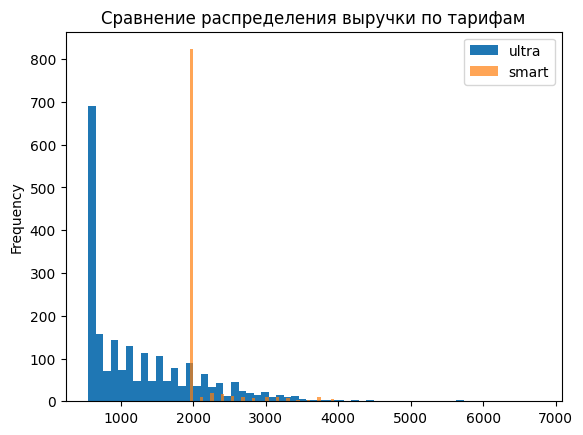

/var/folders/5h/4f18v2q96gv2lm0t_b6g7klc0000gn/T/ipykernel_53988/2035835272.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


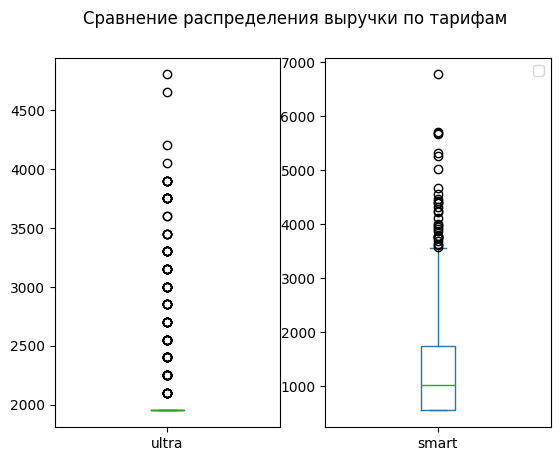

'Доля пользователей smart сферх тарифа'

np.float64(0.7458389563652722)

'Доля пользователей ultra сферх тарифа'

np.float64(0.13459516298633017)

In [78]:
df_income_smart=ces.loc[ces['tariff']=='smart','выручка']

df_income_ultra=ces.loc[ces['tariff']=='ultra','выручка']

display('Статистика выручки у smart:',df_income_smart.describe(),df_income_smart.mean())
display('Статистика выручки у ultra:',df_income_ultra.describe(),df_income_ultra.mean())

df_income_smart.plot(bins=60,kind='hist',label='ultra')
df_income_ultra.plot(bins=60,kind='hist',alpha=0.7,label='smart')
plt.title('Сравнение распределения выручки по тарифам')
plt.legend()
plt.show()

fig, (ax1, ax2) =plt.subplots(1,2)
df_income_ultra.plot(ax=ax1,kind='box',label='ultra')
#ax1.set_ylim(0,250)
df_income_smart.plot(ax=ax2,kind='box',label='smart')
#ax2.set_ylim(0,250)
plt.legend()
plt.suptitle('Сравнение распределения выручки по тарифам')
plt.show()

display('Доля пользователей smart сферх тарифа',df_income_smart[df_income_smart>550].count()/len(df_income_smart))

display('Доля пользователей ultra сферх тарифа',df_income_ultra[df_income_ultra>1950].count()/len(df_income_ultra))


Выводы по распределению минут среди пользователей:

1. Центральная тенденция:
* Smart: среднее = 396 минут, медиана = 399 минут

* Ultra: среднее = 515 минут, медиана = 498 минут

* Вывод: Пользователи ultra в среднем проводят примерно на 119 минут (около 2 часов) больше, чем пользователи smart. Медианы также подтверждают это различие.

2. Разброс данных
* Smart: стандартное отклонение = 179, межквартильный размах (IQR) = 516-269 = 24, дисперсия = 32058

* Ultra: стандартное отклонение = 290, IQR = 715-292.5 = 422.5, дисперсия = 84000

* Вывод: У группы ultra значительно выше вариабельность данных — разброс значений почти в 1.6 раза больше по стандартному отклонению и в 1.7 раза по межквартильному размаху. Значения дисперсий поддтвреждают этот вывод.

3. Форма распределения
* Smart: среднее (396) почти равно медиане (399) → распределение близко к симметричному

* Ultra: среднее (515) > медианы (498) → распределение имеет правостороннюю асимметрию (вытянутый правый хвост)

* Вывод: В группе ultra есть пользователи с экстремально высокими значениями, которые "тянут" среднее вправо.

4. Выбросы и экстремальные значения
* Smart:
    * Максимум = 1355, что значительно выше 3-го квартиля (516) (и лимита на связь в 500)
    * Расстояние от Q3 до максимума = 839 минут (в 3.4 раза больше IQR)

* Ultra:
    * Максимум = 1579, при Q3 = 715 (не достигает лимита в 3000)
    * Расстояние от Q3 до максимума = 864 минуты (в 2 раза больше IQR)

* Вывод: В обеих группах есть сильные выбросы, но в группе smart они более экстремальны относительно основного распределения.


Выводы по распределению кол-ва звонков среди пользователей:
1. Центральная тенденция
* Smart: среднее = 58.6 звонков, медиана = 60 звонков
* Ultra: среднее = 76.0 звонков, медиана = 75 звонков
* Вывод: Пользователи ultra совершают в среднем на 17-18 звонков больше (примерно на 30% больше), чем пользователи smart. Медианы также подтверждают это устойчивое различие.

2. Разброс данных
* Smart: стандартное отклонение = 25.8, межквартильный размах (IQR) = 76-40 = 36 звонков, дисперсия = 665
* Ultra: стандартное отклонение = 42.4, IQR = 105-43 = 62 звонка, дисперсия = 1798
* Вывод: Вариабельность в группе ultra значительно выше — стандартное отклонение больше в 1.64 раза, межквартильный размах больше в 1.72 раза. Это указывает на гораздо более разнообразные паттерны использования среди ultra-пользователей. Значения дисперсии подтверждают этот вывод.

3. Форма распределения
* Smart: среднее (58.6) немного меньше медианы (60) → очень слабая левосторонняя асимметрия (распределение близко к симметричному)
* Ultra: среднее (76.02) практически равно медиане (75) → распределение близко к симметричному, несмотря на наличие выбросов
* Вывод: Оба распределения достаточно симметричны, что нетипично для счетных данных.

4. Выбросы и экстремальные значения
* Smart:
    * Максимум = 198, при Q3 = 76
    * Расстояние от Q3 до максимума = 122 звонка (в 3.4 раза больше IQR)
    * Есть явные выбросы в правом хвосте
* Ultra:
    * Максимум = 244, при Q3 = 105
    * Расстояние от Q3 до максимума = 139 звонков (в 2.24 раза больше IQR)
* Вывод: В обеих группах есть "суперактивные" пользователи с аномально высоким количеством звонков. В группе smart эти выбросы более экстремальны относительно основного распределения (в 3.4 раза превышают IQR против 2.24 в ultra).

Выводы по распределению трафика среди пользователей:
1. Центральная тенденция
* Smart: среднее = 16.34, медиана = 17.00
* Ultra: среднее = 19.70, медиана = 19.00
* Вывод: Пользователи ultra потребляют в среднем на 3.36 единицы трафика больше (примерно на 20.5% больше), чем пользователи smart. Медианы подтверждают это различие (19 против 17).

2. Разброс данных
* Smart: стандартное отклонение = 5.74, межквартильный размах (IQR) = 20-13 = 7 единиц
* Ultra: стандартное отклонение = 9.74, IQR = 27-12 = 15 единиц
* Вывод: Огромный разброс в ultra (в 2.14 раза шире IQR) — это классический признак того, что внутри группы есть несколько различных кластеров пользователей.

3. Форма распределения
* Smart: распределение близко к симметричному, но не является нормальным
* Ultra: нормальное, однако имееться незначительная мультимодальность

4. Выбросы и экстремальные значения
* Smart:
    * Максимум = 38, при Q3 = 20
    * Расстояние от Q3 до максимума = 18 единиц (в 2.57 раза больше IQR)
    * Минимум = 0 (есть пользователи без трафика)
* Ultra:
    * Максимум = 49, при Q3 = 27
    * Расстояние от Q3 до максимума = 22 единицы (в 1.47 раза больше IQR)
    * Минимум = 0 (также есть пользователи без трафика)
* Вывод: В группе smart выбросы более экстремальны относительно основного распределения (в 2.57 против 1.47 раза превышают IQR). При этом абсолютный максимум выше в группе ultra (49 против 38).

Выводы по распределению сообщений среди пользователей:
1. Центральная тенденция (с осторожностью) 
* Smart: среднее = 38.8 сообщений, медиана = 34 сообщения
* Ultra: среднее = 61.2 сообщения, медиана = 52 сообщения
* Вывод: Пользователи ultra отправляют в среднем на 22.4 сообщения больше (примерно на 58% больше), чем пользователи smart. Медианы также подтверждают значительное различие (52 против 34).

2. Разброс данных и признаки мультимодальности
* Smart: стандартное отклонение = 26.8, межквартильный размах (IQR) = 55-17 = 38 сообщений
* Ultra: стандартное отклонение = 44.7, IQR = 88-25 = 63 сообщения
* Вывод: Вариабельность в группе ultra значительно выше — стандартное отклонение больше в 1.67 раза, межквартильный размах больше в 1.66 раза. Это соотношение очень похоже на предыдущие признаки (минуты, звонки, трафик), что подтверждает системно более высокую неоднородность группы ultra.

3. Анализ формы распределения и мультимодальности
* Для группы Smart:
    * Среднее (38.8) > медианы (34) → явная правосторонняя асимметрия
    * IQR: 17-55 (размах 38)
    * Отношение IQR к медиане: 38/34 ≈ 1.12
    * Распределение - унимодально с длинным правым хвостом либо. Основная масса пользователей сконцентрирована в диапазоне 17-55 сообщений, но есть "хвост" тяжелых пользователей, уходящий до 143.

* Для группы Ultra:
    * Среднее (61.2) значительно > медианы (52) → выраженная правосторонняя асимметрия
    * IQR: 25-88 (размах 63) — очень широкий
    * Отношение IQR к медиане: 63/52 ≈ 1.21 (выше, чем в smart)
    * Q1 (25) лишь немного выше, чем в smart (17), но Q3 (88) уже значительно выше (55 в smart)
    * Распределение - унимодально с длинным правым хвостом либо. Основная масса пользователей сконцентрирована в диапазоне 25-88 сообщений, но есть "хвост" тяжелых пользователей, уходящий до 224.

Выводы по распределению выручки среди пользователей:
1. Центральная тенденция (шокирующее открытие)
* Smart: среднее = 1258, медиана = 953
* Ultra: среднее = 2049, медиана = 1950
* Вывод: Пользователи ultra приносят в среднем на 790 единиц выручки больше (примерно на 63% больше), чем пользователи smart.
2. Разброс данных (абсолютно разный характер)
* Smart:
    * std = 805 (очень большой разброс)
    * IQR = 1730-550 = 1180
    * Min = 550, Max = 6614
* Ultra:
    * std = 333 (относительно небольшой, но обманчиво)
    * IQR = 1950-1950 = 0! (полное отсутствие разброса в центральных 50%)
    * Min = 1950, Max = 4800
    * Разброс есть только в верхних 25%

3. Форма распределения
* Smart: распределение с длинным правым хвостом (63.5% пользователей переплачивают)
    * Ultra: распределение с "плато" — 91% данных в одной точке.


Итог:
* Пользователи smart в среднем расходуют меньше минут (399), чем пользователи ultra (498). Среди пользователей ultra нет тех, кто превысил лимит минут (3000 мин.), среди пользователей smart таких пользователей 28% (что объясненяется более жесткими условиями тарифа - лимит в 500 мин.). Группа пользователей ultra более вариативна, нежели группа пользователей smart (объяснить это можно также более жесткими условиями тарифов).
* Пользователи smart в среднем совершают меньше звонков (60), чем пользователи ultra (75). Группа пользователей ultra более вариативна, нежели группа пользователей smart (разброс значений почти в 1.7 раза шире). Оба распределения достаточно симметричны (обычно дискретные переменные имеют правостороннюю ассиметрию). Также нижние квартирли достаточно близки ("слабые" пользователи обоих тарифов ведут себя примерно одинаково, а основные различия начинаются в верхней половине распределения.)
* Пользователи smart в среднем тратят меньше трафика (17), чем пользователи ultra (19). Группа пользователей ultra более вариативна, нежели группа пользователей smart (разброс в 2.14 раза шире по межквартильному размаху). 25% самых "экономичных" пользователей ultra потребляют меньше трафика (12), чем аналогичная группа smart (13) (вероятно, часть пользователей выбрала ultra-тариф не из-за потребностей в интернете). 25% самых активных пользователей ultra потребляют 27+ единиц против 20+ в smart (разрыв в "тяжелых" пользователях значителен)
* Самая выраженная разница между тарифами — по сообщениям пользователи ultra превосходят smart на 53% (по медиане). Оба распределения имеют правостороннюю асимметрию, причем у ultra она выражена сильнее. Это означает, что в обеих группах есть "суперактивные" пользователи, которые тянут среднее вправо. Значительная доля пользователей не пользуется сообщениями — 14% в smart и 20% в ultra имеют нулевое количество сообщений (исключены из выборки). Это важный поведенческий паттерн: пятая часть пользователей ultra игнорирует этот сервис.


Шаг 4. Проверим гипотезы
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H_0: средние выручки пользователей тарифов «Ультра» и «Смарт» равны
H_1: средние выручки пользователей тарифов «Ультра» и «Смарт» различаются

In [79]:
lev_res=(st.levene(df_income_smart.fillna(0),df_income_ultra.fillna(0)))

display(lev_res)

if lev_res.pvalue<0.01:
    display('Дисперсии различны')
else:
    display('Дисперсии равны')

res_ttest=(st.ttest_ind(df_income_smart.fillna(0),df_income_ultra.fillna(0),equal_var=False))

display(res_ttest)

if res_ttest.pvalue<0.01:
    display('Отвергаем H0 берем H1')
else:
    display('Не отвергаем H0')

LeveneResult(statistic=np.float64(589.6587880286635), pvalue=np.float64(1.3049382984836004e-119))

'Дисперсии различны'

TtestResult(statistic=np.float64(-36.64338942040299), pvalue=np.float64(3.1551732058665752e-245), df=np.float64(3154.080089067292))

'Отвергаем H0 берем H1'

H_0: средние выручки пользователей из Москвы и остальных пользователей равны
H_1: средние выручки пользователей из Москвы и остальных пользователей различаются

In [80]:
ces=ces.merge(df_users[['city','user_id']])

df_income_msc=ces.loc[(ces['city']=='Москва'),'выручка']

df_income_not_msc=ces.loc[(ces['city']!='Москва'),'выручка']

lev_res=(st.levene(df_income_msc.dropna(),df_income_not_msc.dropna()))

display(lev_res)

if lev_res.pvalue<0.01:
    display('Дисперсии различны')
else:
    display('Дисперсии равны')

res_ttest=(st.ttest_ind(df_income_msc.dropna(),df_income_not_msc.dropna(),equal_var=True))

display(res_ttest)

if res_ttest.pvalue<0.01:
    display('Отвергаем H0 берем H1')
else:
    display('Не отвергаем H0')

LeveneResult(statistic=np.float64(6.481451843651279), pvalue=np.float64(0.010947505956803421))

'Дисперсии равны'

TtestResult(statistic=np.float64(0.7356580412955895), pvalue=np.float64(0.4619932225305272), df=np.float64(3172.0))

'Не отвергаем H0'

### Общий вывод

Тарифы ориентированы на разные модели потребления:

Smart подходит пользователям со средним уровнем активности, однако из-за ограниченных пакетов часто приводит к дополнительным расходам.

Ultra ориентирован на активных пользователей, которым важно отсутствие жёстких ограничений и предсказуемость затрат.

С точки зрения бизнеса:

Ultra приносит более высокую среднюю выручку на пользователя.

Smart может быть более прибыльным при большом количестве клиентов за счёт частых перерасходов.

Исследование подтвердило наличие статистически значимых различий между тарифами и показало отсутствие регионального влияния на выручку.